# Prepare Dataset

## Install Datasets

In [ ]:
# Install pycocotools to work with the COCO dataset in Python
!pip install pycocotools

In [ ]:
# Create directories for storing the COCO dataset
!mkdir -p /content/coco_dataset
!cd /content/coco_dataset

# Download COCO 2017 images and annotations
!wget http://images.cocodataset.org/zips/train2017.zip -P /content/coco_dataset
!wget http://images.cocodataset.org/zips/val2017.zip -P /content/coco_dataset
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/coco_dataset

# Unzip the files
!unzip /content/coco_dataset/train2017.zip -d /content/coco_dataset/
!unzip /content/coco_dataset/val2017.zip -d /content/coco_dataset/
!unzip /content/coco_dataset/annotations_trainval2017.zip -d /content/coco_dataset/


Streaming output truncated to the last 5000 lines.
 extracting: /content/coco_dataset/val2017/000000365745.jpg  
 extracting: /content/coco_dataset/val2017/000000320425.jpg  
 extracting: /content/coco_dataset/val2017/000000481404.jpg  
 extracting: /content/coco_dataset/val2017/000000314294.jpg  
 extracting: /content/coco_dataset/val2017/000000335328.jpg  
 extracting: /content/coco_dataset/val2017/000000513688.jpg  
 extracting: /content/coco_dataset/val2017/000000158548.jpg  
 extracting: /content/coco_dataset/val2017/000000132116.jpg  
 extracting: /content/coco_dataset/val2017/000000415238.jpg  
 extracting: /content/coco_dataset/val2017/000000321333.jpg  
 extracting: /content/coco_dataset/val2017/000000081738.jpg  
 extracting: /content/coco_dataset/val2017/000000577584.jpg  
 extracting: /content/coco_dataset/val2017/000000346905.jpg  
 extracting: /content/coco_dataset/val2017/000000433980.jpg  
 extracting: /content/coco_dataset/val2017/000000228144.jpg  
 extracting: /conte

## Load dataset

In [8]:
coco_labels = {
    1: "person",
    2: "bicycle",
    3: "car",
    4: "motorcycle",
    5: "airplane",
    6: "bus",
    7: "train",
    8: "truck",
    9: "boat",
    10: "traffic light",
    11: "fire hydrant",
    12: "stop sign",
    13: "parking meter",
    14: "bench",
    15: "bird",
    16: "cat",
    17: "dog",
    18: "horse",
    19: "sheep",
    20: "cow",
    21: "elephant",
    22: "bear",
    23: "zebra",
    24: "giraffe",
    25: "hat",
    26: "backpack",
    27: "umbrella",
    28: "handbag",
    29: "tie",
    30: "suitcase",
    31: "frisbee",
    32: "skis",
    33: "snowboard",
    34: "sports ball",
    35: "kite",
    36: "baseball bat",
    37: "baseball glove",
    38: "skateboard",
    39: "surfboard",
    40: "tennis racket",
    41: "bottle",
    42: "wine glass",
    43: "cup",
    44: "fork",
    45: "knife",
    46: "spoon",
    47: "bowl",
    48: "banana",
    49: "apple",
    50: "sandwich",
    51: "orange",
    52: "broccoli",
    53: "carrot",
    54: "hot dog",
    55: "pizza",
    56: "donut",
    57: "cake",
    58: "chair",
    59: "couch",
    60: "potted plant",
    61: "bed",
    62: "dining table",
    63: "toilet",
    64: "tv",
    65: "laptop",
    66: "mouse",
    67: "remote",
    68: "keyboard",
    69: "cell phone",
    70: "microwave",
    71: "oven",
    72: "toaster",
    73: "sink",
    74: "refrigerator",
    75: "book",
    76: "clock",
    77: "vase",
    78: "scissors",
    79: "teddy bear",
    80: "hair drier",
    81: "toothbrush"
}

In [17]:
import torch
import torchvision
from pycocotools.coco import COCO
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Resize, Normalize, Lambda
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image
import os
import numpy as np

class COCODataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transforms=None):
        self.coco = COCO(annFile)
        self.root = root
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Load image
        path = self.coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert("RGB")
        orig_width, orig_height = img.size

        # Load annotations
        boxes = []
        labels = []
        for ann in anns:
            boxes.append(ann['bbox'])  # COCO uses [x_min, y_min, width, height] format
            labels.append(ann['category_id'])

        if self.transforms is not None:
            img = self.transforms(img)

            boxes = torch.tensor(boxes)
            # Robustness checks
            if boxes.numel() == 0:
              print(f"Warning: No boxes found for image with index {idx}, returning default values.")
              # Return default values instead of None
              return img, torch.tensor([[0, 0, 0, 0]]), torch.tensor([0]) # Adjust default values as needed
            if len(boxes.shape) < 2:
                boxes = boxes.unsqueeze(0)
            assert boxes.shape[1] == 4, "Box dimensions should be (x, y, w, h)"

            # Rescale boxes
            boxes[:, 0] *= img.size(2) / orig_width  # x_min
            boxes[:, 1] *= img.size(1) / orig_height  # y_min
            boxes[:, 2] *= img.size(2) / orig_width  # width
            boxes[:, 3] *= img.size(1) / orig_height  # height

        return img, boxes, torch.tensor(labels)

    def __len__(self):
        return len(self.ids)

# Transformation pipeline
transform = Compose([
    Resize((800, 800)),
    ToTensor(),
])

# Setup COCO dataset and DataLoader
data_dir = '/content/coco_dataset'
train_annotations = f'{data_dir}/annotations/instances_train2017.json'
val_annotations = f'{data_dir}/annotations/instances_val2017.json'

train_dataset = COCODataset(root=f'{data_dir}/train2017', annFile=train_annotations, transforms=transform)
val_dataset = COCODataset(root=f'{data_dir}/val2017', annFile=val_annotations, transforms=transform)

train_subset = torch.utils.data.Subset(train_dataset, indices=range(100))
val_subset = torch.utils.data.Subset(val_dataset, indices=range(10))

train_loader = DataLoader(train_subset, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, num_workers=4)

loading annotations into memory...
Done (t=29.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [21]:
image, boxes, labels = next(iter(train_loader))
print(image.shape)
print(boxes.shape)
print(labels)

torch.Size([1, 3, 800, 800])
torch.Size([1, 1, 4])
tensor([[70]])


## Show an example dataset

tensor(4)
tensor(1)
tensor(1)
tensor(2)
tensor([[448.9625, 324.8222, 140.5625, 474.6000],
        [424.8500,  49.2444, 192.3500, 668.2889],
        [589.5500, 384.0445,  44.9000, 106.8889],
        [607.5125, 407.3556,  38.2875,  77.7333]])
tensor([[448.9625, 324.8222, 140.5625, 474.6000],
        [424.8500,  49.2444, 192.3500, 668.2889],
        [589.5500, 384.0445,  44.9000, 106.8889],
        [607.5125, 407.3556,  38.2875,  77.7333]])
tensor([[448.9625, 324.8222, 140.5625, 474.6000],
        [424.8500,  49.2444, 192.3500, 668.2889],
        [589.5500, 384.0445,  44.9000, 106.8889],
        [607.5125, 407.3556,  38.2875,  77.7333]])
tensor([[448.9625, 324.8222, 140.5625, 474.6000],
        [424.8500,  49.2444, 192.3500, 668.2889],
        [589.5500, 384.0445,  44.9000, 106.8889],
        [607.5125, 407.3556,  38.2875,  77.7333]])


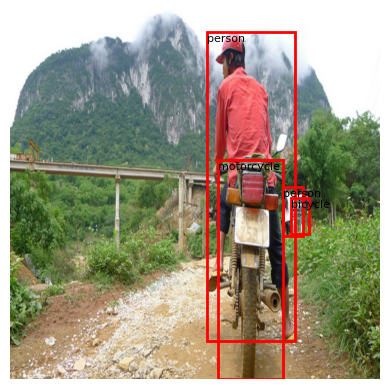

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first element from the train_dataset
image, boxes, labels = train_dataset[0]  # Index 0 refers to the first image-annotation pair

# Convert the image back to a numpy array for plotting
image = image.permute(1, 2, 0).numpy()  # Convert [C, H, W] to [H, W, C]

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide the axis

for label in labels:
  print(label)

# If target is a list of annotations (usually it is)
for i, box in enumerate(boxes):
    print(boxes)
    x, y, width, height = box
    rect = plt.Rectangle((x, y), width, height, fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)

    label = coco_labels.get(labels[i].item(), "Unknown")
    plt.text(x, y + 20, label, color='Black', fontsize=8)

plt.show()

# Model DETR

In [1]:
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import torch.nn.functional as F
import math

In [11]:
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, nheads):
        super().__init__()
        self.query_linear = nn.Linear(hidden_dim, hidden_dim)
        self.key_linear = nn.Linear(hidden_dim, hidden_dim)
        self.value_linear = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, query, key, value):
        Q = self.query_linear(query)
        K = self.key_linear(key)
        V = self.value_linear(value)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(Q.shape[-1])
        weights = F.softmax(scores, dim=-1)
        weights = self.dropout(weights)
        output = torch.matmul(weights, V)
        return output


class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class TransformerLayer(nn.Module):
    def __init__(self, hidden_dim, nheads):
        super().__init__()
        self.self_attn = MultiHeadAttention(hidden_dim, nheads)
        self.feed_forward = FeedForwardNetwork(hidden_dim)

    def forward(self, src):
        src = self.self_attn(src, src, src)
        src = self.feed_forward(src)
        return src


class CustomTransformer(nn.Module):
    def __init__(self, hidden_dim, nheads, num_encoder_layers, num_decoder_layers):
        super().__init__()
        self.encoder_layers = nn.ModuleList([TransformerLayer(hidden_dim, nheads) for _ in range(num_encoder_layers)])
        self.decoder_layers = nn.ModuleList([TransformerLayer(hidden_dim, nheads) for _ in range(num_decoder_layers)])

    def forward(self, src, tgt):
        # print(src)
        # print(src.size())
        # print(tgt)
        # print(tgt.size())
        for layer in self.encoder_layers:
            src = layer(src)

        for layer in self.decoder_layers:
            tgt = layer(tgt)

        return tgt

In [3]:
class DETR(nn.Module):
    """
    Demo DETR implementation.

    implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a custom transformer
        self.transformer = CustomTransformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.mlp_bbox = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),  # Layer 1
            nn.ReLU(),  # Activation
            nn.Linear(hidden_dim, hidden_dim),  # Layer 2
            nn.ReLU(),  # Activation
            nn.Linear(hidden_dim, 4)  # Output layer: bounding box (x, y, w, h)
        )

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        pred_logits = self.linear_class(h)
        probabilities = torch.softmax(pred_logits, dim=-1) + 1e-8  # Scale probabilities

        # Bounding box prediction using 3-layer MLP
        pred_boxes = self.mlp_bbox(h).sigmoid()  # Output bounding boxes as (x, y, w, h)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': probabilities,
            'pred_boxes': pred_boxes}

In [4]:
import torch

def detr_loss(pred_logits, pred_boxes, target_labels, target_boxes):
    """
    Computes the DETR loss.

    Args:
        pred_logits (tensor): Predicted class logits (1, 100, 92).
        pred_boxes (tensor): Predicted boxes (1, 100, 4).
        target_labels (tensor): Ground truth class indices (1, num_boxes).
        target_boxes (tensor): Ground truth boxes (1, num_boxes, 4).

    Returns:
        loss (tensor): DETR loss.
    """
    # One-hot encoding for target labels
    num_classes = pred_logits.shape[-1]
    target_labels_onehot = torch.zeros((target_labels.shape[0], target_labels.shape[1], num_classes)).to(target_labels.device)
    target_labels_onehot.scatter_(2, target_labels.unsqueeze(2), 1)

    # Compute matching cost
    matching_cost = torch.zeros(target_labels.shape[1], pred_logits.shape[1]).to(target_labels.device)
    for i in range(target_labels.shape[1]):
        for j in range(pred_logits.shape[1]):
            matching_cost[i, j] = -pred_logits[0, j, target_labels[0, i].long()] + box_loss(target_boxes[0, i], pred_boxes[0, j])

    # Hungarian algorithm
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(matching_cost.detach().cpu().numpy())

    # Compute loss
    loss = 0
    for i, j in zip(row_ind, col_ind):
        loss_term = -torch.log(pred_logits[0, j, target_labels[0, i].long()]) + box_loss(target_boxes[0, i], pred_boxes[0, j])
        # Check NaN loss term
        if torch.isnan(loss_term):
            print(pred_logits[0, j, target_labels[0, i].long()])
            print(f"Label Loss: {-torch.log(pred_logits[0, j, target_labels[0, i].long()])}")
            print(f"Box loss logits: {box_loss(target_boxes[0, i], pred_boxes[0, j])}")
            print("NaN loss term encountered!")
            loss_term = torch.zeros_like(loss_term)
        loss += loss_term

    return loss


def box_loss(bi, b_hat):
    """
    Computes the box loss (L1 + IoU).

    Args:
        bi (tensor): Ground truth box (4).
        b_hat (tensor): Predicted box (4).

    Returns:
        loss (tensor): Box loss.
    """

    # L1 loss
    l1_loss = torch.sum(torch.abs(bi - b_hat))

    # IoU loss
    iou_loss = 1 - iou(bi, b_hat)

    return l1_loss + iou_loss


def iou(box1, box2):
    """
    Computes the IoU of two boxes.

    Args:
        box1 (tensor): Box 1 (4).
        box2 (tensor): Box 2 (4).

    Returns:
        iou (tensor): IoU.
    """

    # Intersection
    intersection = torch.min(box1[2], box2[2]) * torch.min(box1[3], box2[3])

    # Union
    union = box1[2] * box1[3] + box2[2] * box2[3] - intersection

    return intersection / union

# Train/Test

In [5]:
def train_one_epoch(model, criterion, optimizer, data_loader, device):
    model.train()
    total_loss = 0

    for images, boxes, labels in data_loader:
        images = images.to(device)
        target_labels = labels.to(device).long()
        target_boxes = boxes.to(device).float()

        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)

        pred_logits = outputs['pred_logits']
        pred_boxes = outputs['pred_boxes']

        # Compute loss
        loss = criterion(pred_logits, pred_boxes, target_labels, target_boxes)

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

    # Calculate epoch loss and accuracy
    epoch_loss = total_loss / len(data_loader)

    # Print epoch loss
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    return epoch_loss


In [13]:
def validate_one_epoch(model, criterion, data_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, boxes, labels in data_loader:
            images = images.to(device)
            target_labels = labels.to(device).long()
            target_boxes = boxes.to(device).float()

            # Forward pass
            outputs = model(images)
            pred_logits = outputs['pred_logits']
            pred_boxes = outputs['pred_boxes']

            # Compute loss
            loss = criterion(pred_logits, pred_boxes, target_labels, target_boxes)

            # Accumulate loss and accuracy
            total_loss += loss.item()

    # Calculate epoch loss and accuracy
    epoch_loss = total_loss / len(data_loader)

    print(f"Validation Loss: {epoch_loss:.4f}")

    return epoch_loss

In [18]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DETR(num_classes=91).to(device)
criterion = detr_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

training_loss = []
validation_loss = []
epoch_list = []

epochs = 10
print("Training:")
for epoch in range(epochs):
    # Training loop
    loss = train_one_epoch(model, criterion, optimizer, train_loader, device)
    training_loss.append(loss)

    loss = validate_one_epoch(model, criterion, val_loader, device)
    validation_loss.append(loss)

    epoch_list.append(epoch)

Training:
Epoch 1, Loss: 176.5544
Validation Loss: 9300.8578
Epoch 2, Loss: 193.2527
Validation Loss: 9300.8133
Epoch 3, Loss: 85.8851
Validation Loss: 9300.7763
Epoch 4, Loss: 56.0781
Validation Loss: 9300.7430
Epoch 5, Loss: 91.4570
Validation Loss: 9300.7071
Epoch 6, Loss: 112.7774
Validation Loss: 9300.6729
Epoch 7, Loss: 0.0760
Validation Loss: 9300.6432
Epoch 8, Loss: 89.3772
Validation Loss: 9300.6154
Epoch 9, Loss: 59.2040
Validation Loss: 9300.5880
Epoch 10, Loss: 14.2295
Validation Loss: 9300.5620


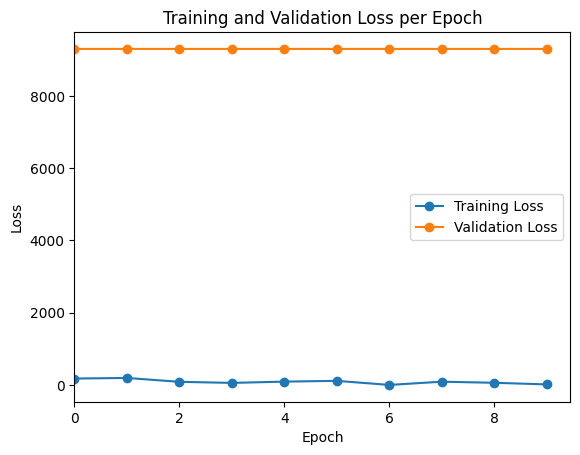

In [19]:
# Plot training and validation loss
plt.plot(epoch_list, training_loss, label='Training Loss', marker='o')
plt.plot(epoch_list, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.xlim(left=0)  # Ensure x-axis starts at 0
plt.show()


# Test model

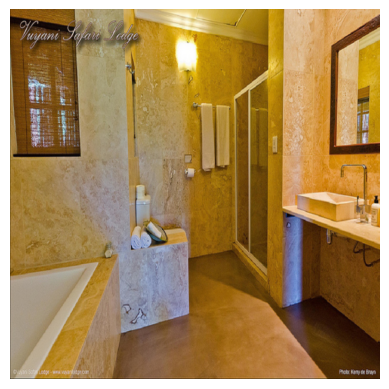

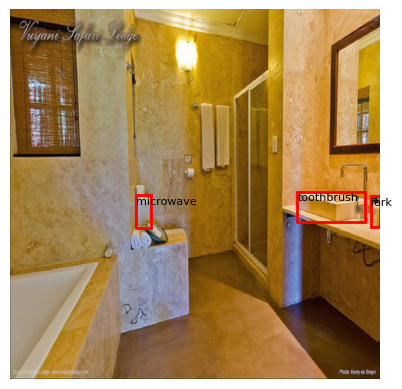

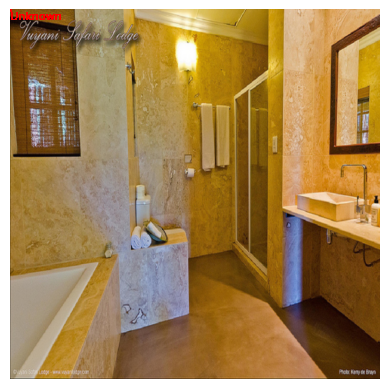

In [20]:
# Example: load a single image from the validation set
val_loader = train_loader
images, boxes, labels = next(iter(val_loader))  # Get one batch (image, target)

# Move image and target to the appropriate device (GPU/CPU)
image = images.to(device)

# Forward pass
outputs = model(image)
pred_logits = outputs['pred_logits']
pred_boxes = outputs['pred_boxes']

# Plot the image
image = image.squeeze().cpu().numpy()  # Remove batch dimension, now shape is (3, 800, 800)

# Transpose the image to (H, W, C) for matplotlib
image = np.transpose(image, (1, 2, 0))  # Convert to shape (800, 800, 3)

# Ensure the pixel values are between 0 and 1 if not already
image = np.clip(image, 0, 1)

# Show original image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

# Show the image with actual labels
plt.imshow(image)
plt.axis('off')  # Hide the axis

# If target is a list of annotations (usually it is)
for i, box in enumerate(boxes[0]):
    x, y, width, height = box
    rect = plt.Rectangle((x, y), width, height, fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)

    label = coco_labels.get(labels[0][i].item(), "Unknown")
    plt.text(x, y + 20, label, color='Black', fontsize=8)
plt.show()

# Show image with labels
plt.imshow(image)
plt.axis('off')  # Hide the axis

# If target is a list of annotations (usually it is)
pred_boxes_array = pred_boxes.detach().numpy()
pred_class_indices = torch.argmax(pred_logits, dim=-1)
for i, box in enumerate(pred_boxes_array[0]):
    x, y, width, height = box
    rect = plt.Rectangle((x, y), width, height, fill=False, color='red', linewidth=2)
    plt.gca().add_patch(rect)

    class_idx = pred_class_indices[0][i]  # Predicted class index
    label = coco_labels.get(class_idx, "Unknown")  # Replace with the actual label lookup
    plt.text(x, y + 20, label, color='Red', fontsize=8)

plt.show()